In [1]:
import matplotlib.pyplot as plt
import openfermion as of
from Hubbard_Model_nnn import *
import jax.numpy as jnp
from itertools import product
from jax import config
from numpy.polynomial.chebyshev import Chebyshev
from scipy.io import loadmat
import scipy.sparse as sp
import glob
config.update("jax_enable_x64", True)

# Set parameters.

In [2]:
# Parameters.
x_dimension = 2
y_dimension = 2
n_up = 2
n_down = 2

n_site = x_dimension * y_dimension

U = 2
t = 1.0
t_prime = 0.3
mu = 0.0

## Construct the reduced Hamiltonian.

In [3]:
def reduced_hubbard_model(U, indices):
    hopping_terms = fermi_hubbard_nnn(x_dimension, y_dimension, tunneling=t, nnn_tunneling=t_prime, coulomb=U, chemical_potential=mu, periodic=True)
    hopping_terms = of.get_sparse_operator(hopping_terms)
    H_hubbard = hopping_terms[jnp.ix_(indices, indices)].toarray()

    return H_hubbard

In [4]:
valid_indices = []
for bits in product('01', repeat= 2 * x_dimension * y_dimension):

    spin_up_indices = bits[::2]
    spin_down_indices = bits[1::2]

    if spin_up_indices.count('1') == n_up and spin_down_indices.count('1') == n_down:
        binary_str = ''.join(bits)
        valid_indices.append(int(binary_str, 2))

reduced_H_indices = jnp.array(valid_indices)

H_reduced = reduced_hubbard_model(U=U, indices=reduced_H_indices)
reduced_dim = len(H_reduced)
print('reduced_dim =', reduced_dim)

H_reduced_eigvals, H_reduced_eigvecs = jnp.linalg.eigh(H_reduced)
print(f"Eigenvalues:", jnp.round(H_reduced_eigvals[:8], 3))

reduced_dim = 36
Eigenvalues: [-6.682 -6.586 -5.825 -5.571 -5.015 -5.015 -3.99  -3.99 ]


In [5]:
U_sweep_ED = jnp.linspace(0, U, 80)

H_eigvals_sweep = []

for UU in U_sweep_ED:
    H = reduced_hubbard_model(U=float(UU), indices=reduced_H_indices)
    eigvals = jnp.linalg.eigvalsh(H)
    H_eigvals_sweep.append(eigvals)

H_eigvals_sweep = jnp.array(H_eigvals_sweep).T

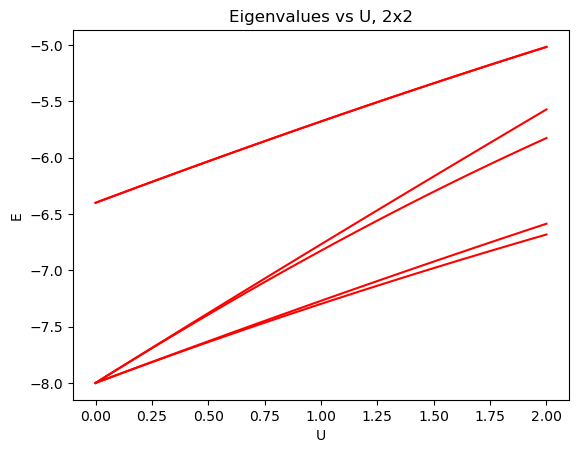

In [6]:
for band in range(6):
    plt.plot(U_sweep_ED, H_eigvals_sweep[band], 'red')


plt.xlabel('U')
plt.ylabel('E')
plt.title(f'Eigenvalues vs U, {x_dimension}x{y_dimension}')
# plt.ylim(jnp.min(solved_eigvals) - 0.5, jnp.max(solved_eigvals) + 0.5)

# plt.legend()
plt.show()

# Schur complement

In [7]:
def find_degeneracies(E0, tol=1E-10):

    sorted_indices = jnp.argsort(E0)
    sorted_E0 = jnp.array(E0)[sorted_indices]
    
    degeneracy_counts = []

    current_degeneracy = 1

    for i in range(1, len(sorted_E0)):
        if jnp.abs(sorted_E0[i] - sorted_E0[i - 1]) < tol:

            current_degeneracy += 1
        else:

            degeneracy_counts.append(current_degeneracy)
            current_degeneracy = 1

    degeneracy_counts.append(current_degeneracy)
    
    return degeneracy_counts

def degenerate_states(Hi, H0_eigvecs, degeneracy_counts):

    start_index = 0
    for i, count in enumerate(degeneracy_counts):
        
        P = H0_eigvecs[:, start_index:start_index+count]
        P_T = jnp.conj(P.T)
        Hi_proj = P_T @ Hi @ P

        Hi_eigvals, Hi_eigvecs = jnp.linalg.eigh(Hi_proj)
        Hi_eigvecs = P @ Hi_eigvecs
        
        if i == 0:
            print("Eigenvalues of first Hi: \n", Hi_eigvals)
        
        H0_eigvecs = H0_eigvecs.at[:, start_index:start_index + count].set(Hi_eigvecs)
        start_index += count

    return H0_eigvecs

In [8]:
H0 =  reduced_hubbard_model(U=0, indices=reduced_H_indices)

H0_eigvals, H0_eigvecs = jnp.linalg.eigh(H0)
print("Eigenvalues of H0: \n", jnp.round(H0_eigvals[:8], 3))

Hi = reduced_hubbard_model(U=1, indices=reduced_H_indices) - H0

Eigenvalues of H0: 
 [-8.  -8.  -8.  -8.  -6.4 -6.4 -6.4 -6.4]


In [9]:
degeneracy_counts = find_degeneracies(H0_eigvals[:], tol=1E-10)
print("Number of degerate Eigenvalues:\n", degeneracy_counts)
k = sum(degeneracy_counts[:1])

degeneracy_counts = find_degeneracies(H0_eigvals[:k], tol=1E-10)
print("Number of degerate Eigenvalues:\n", degeneracy_counts)
H0_eigvecs_updated = degenerate_states(Hi, H0_eigvecs[:, :k], degeneracy_counts)
H0_eigvals_updated = H0_eigvals[:k]

degeneracy_idx = [0, k-1]
degeneracy_dim = degeneracy_idx[1] - degeneracy_idx[0] + 1

Number of degerate Eigenvalues:
 [4, 4, 1, 4, 10, 4, 1, 4, 4]
Number of degerate Eigenvalues:
 [4]
Eigenvalues of first Hi: 
 [0.75 0.75 1.25 1.25]


In [10]:
def Schur_complement(H, E, init_eigvecs, degeneracy_idx, dim):
    degeneracy_dim = degeneracy_idx[1] - degeneracy_idx[0] + 1
    degeneracy_eigvecs = init_eigvecs[:, degeneracy_idx[0]:degeneracy_idx[1] + 1]
    Hij = jnp.conj(degeneracy_eigvecs.T) @ H @ degeneracy_eigvecs

    alpha = 1
    gamma = 1E-10
    
    O = jnp.zeros((dim, dim))
    for d in range(degeneracy_dim):
        O += jnp.outer(degeneracy_eigvecs[:, d], jnp.conj(degeneracy_eigvecs[:, d]))
    Q = jnp.eye(dim) - O
    M = alpha * O + Q @ (E * jnp.eye(dim) - H) @ Q + gamma * 1j * jnp.eye(dim)

    # C = O @ H @ O
    # print(jnp.linalg.det(C-H))
    M_inv = jnp.linalg.inv(M)

    Rij = jnp.conj(degeneracy_eigvecs.T) @ H @ Q @ M_inv @ Q @ H @ degeneracy_eigvecs

    return jnp.real(Hij + Rij - E * jnp.eye(degeneracy_dim))

In [11]:
def Schur_complement_qsp(H, E, init_eigvecs, degeneracy_idx, dim, poly, kappa):
    degeneracy_dim = degeneracy_idx[1] - degeneracy_idx[0] + 1
    degeneracy_eigvecs = init_eigvecs[:, degeneracy_idx[0]:degeneracy_idx[1] + 1]
    Hij = jnp.conj(degeneracy_eigvecs.T) @ H @ degeneracy_eigvecs

    alpha = 1
    gamma = 1E-10
    
    O = jnp.zeros((dim, dim))
    for d in range(degeneracy_dim):
        O += jnp.outer(degeneracy_eigvecs[:, d], jnp.conj(degeneracy_eigvecs[:, d]))
    Q = jnp.eye(dim) - O
    M = alpha * O + Q @ (E * jnp.eye(dim) - H) @ Q + gamma * 1j * jnp.eye(dim)

    N = jnp.linalg.norm(M)
    M = M / N
    
    M_eigvals, M_eigvecs = jnp.linalg.eigh(M)
    M_eigvals_inv = jnp.diag(poly(M_eigvals))
    M_inv = M_eigvecs @ M_eigvals_inv @ jnp.conj(M_eigvecs.T) * 2 * kappa / N

    Rij = jnp.conj(degeneracy_eigvecs.T) @ H @ Q @ M_inv @ Q @ H @ degeneracy_eigvecs

    return jnp.real(Hij + Rij - E * jnp.eye(degeneracy_dim))

In [12]:
def QHQ_spectrum(H, init_eigvecs, degeneracy_idx, dim):
    degeneracy_dim = degeneracy_idx[1] - degeneracy_idx[0] + 1
    degeneracy_eigvecs = init_eigvecs[:, degeneracy_idx[0]:degeneracy_idx[1] + 1]
    
    O = jnp.zeros((dim, dim))
    for d in range(degeneracy_dim):
        O += jnp.outer(degeneracy_eigvecs[:, d], jnp.conj(degeneracy_eigvecs[:, d]))
    Q = jnp.eye(dim) - O
    QHQ = Q @ H @ Q

    spectrum = jnp.linalg.eigh(QHQ)

    return spectrum

In [13]:
QHQ_eigvals, QHQ_eigvecs = QHQ_spectrum(H=H_reduced, init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx, dim=reduced_dim)

## Eigenbranches (error $ = 10^{-3}$)

In [14]:
kappa = 80
error = 3
file_name = f'coef_kappa{kappa}_error1e-{error}*'
file = glob.glob(file_name)
pcoefs = loadmat(file[0])
pcoefs = pcoefs['coef_full']

pcoefs = jnp.array([coef[0] for coef in pcoefs])
poly = Chebyshev(pcoefs)

In [15]:
Xlim = [H_reduced_eigvals[0] - 0.1, H_reduced_eigvals[10] + 0.1]
N_plot = 500
Energy = jnp.linspace(Xlim[0], Xlim[1], N_plot)

In [16]:
Eigenbranches = []
for En in Energy:
    Schur = Schur_complement_qsp(H=H_reduced, E=En, init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx, dim=reduced_dim, poly=poly, kappa=kappa)
    sub_eigvals = jnp.linalg.eigvalsh(Schur)
    Eigenbranches.append(sub_eigvals)
Eigenbranches = jnp.array(Eigenbranches).T

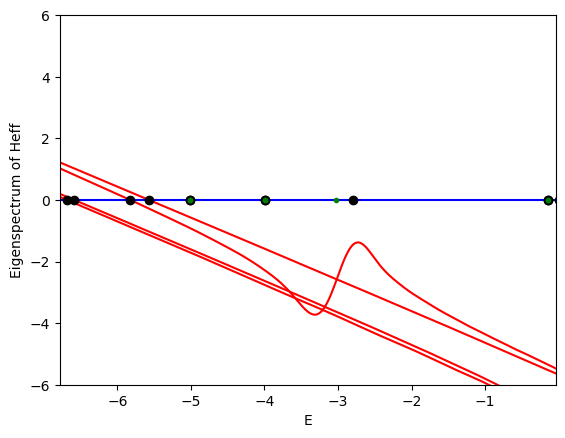

In [17]:
plt.xlabel('E')
plt.ylabel('Eigenspectrum of Heff')
plt.xlim(Xlim[0], Xlim[1])
# plt.xlim(4, 7)
plt.ylim(-6, 6)

for Eigenbranch in Eigenbranches:
    plt.plot(Energy, Eigenbranch, 'red')

plt.axhline(y=0, color='blue')

plt.plot(H_reduced_eigvals, jnp.zeros_like(H_reduced_eigvals), 'o', color='black')
plt.plot(QHQ_eigvals, jnp.zeros_like(QHQ_eigvals), 'o', color='green', markersize=3)

plt.show()

# Binary search 
### ($\Delta U = 0.2$)

## error $ = 10^{-3}$

In [18]:
kappa = 80
error = 3
file_name = f'coef_kappa{kappa}_error1e-{error}*'
file = glob.glob(file_name)
pcoefs = loadmat(file[0])
pcoefs = pcoefs['coef_full']

pcoefs = jnp.array([coef[0] for coef in pcoefs])
poly = Chebyshev(pcoefs)

In [19]:
U_sweep = jnp.linspace(0, U, 11)

In [20]:
solved_eigvals = [[vals.item() for vals in H0_eigvals_updated]]

def binary_search_solver(Schur_complement, x0, subspace_eigvals_idx, E_cutoff=10**(-error), max_iter=100):

    def f(x):
        Schur = Schur_complement(x)
        sub_eigvals = jnp.linalg.eigvalsh(Schur)
        return sub_eigvals[subspace_eigvals_idx]

    xn = x0[subspace_eigvals_idx]
    fn = f(x0[subspace_eigvals_idx])

    # Iterative binary search
    for iteration in range(max_iter):
        # Update bounds based on fn's sign
        if fn < 0:
            upper_bound = xn
            lower_bound = fn + xn
        else:
            upper_bound = fn + xn
            lower_bound = xn

        # Update midpoint
        xn = (lower_bound + upper_bound) / 2

        # Update the function value at xn
        fn = f(xn)

        # Check for convergence
        if jnp.abs(fn) < E_cutoff:
            print(f"Converged in {iteration} iterations.")
            print(xn)
            return xn.item()

    print("Binary search did not converge within the maximum number of iterations.")
    print(xn)
    return xn.item()


for i, UU in enumerate(U_sweep):
    # Skip the first iteration
    if i == 0:
        continue
    print('solve:', i)
    
    # Construct the Hamiltonian for the coulomb = U
    H = reduced_hubbard_model(U=float(UU), indices=reduced_H_indices)
    
    # Use binary search to solve the eigenvalues of different band
    solved_eigval = []
    for subspace_eigvals_idx in range(k):
        subspace_solved_eigval = binary_search_solver(Schur_complement=lambda x: Schur_complement_qsp(H=H, E=x, init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx, dim=reduced_dim, poly=poly, kappa=kappa), 
                                                x0=solved_eigvals[-1], subspace_eigvals_idx=subspace_eigvals_idx)
        solved_eigval.append(subspace_solved_eigval)
    solved_eigvals.append(solved_eigval)
solved_eigvals = jnp.array(solved_eigvals).T

solve: 1
Converged in 7 iterations.
-7.85263204684159
Converged in 7 iterations.
-7.851373440332533
Converged in 7 iterations.
-7.753767155246871
Converged in 7 iterations.
-7.75175551825927
solve: 2
Converged in 7 iterations.
-7.708620157846292
Converged in 7 iterations.
-7.703744739234892
Converged in 7 iterations.
-7.512355922553455
Converged in 7 iterations.
-7.504049291438714
solve: 3
Converged in 7 iterations.
-7.5681285543589905
Converged in 7 iterations.
-7.557736549281236
Converged in 7 iterations.
-7.277009315402273
Converged in 7 iterations.
-7.257749754087975
solve: 4
Converged in 7 iterations.
-7.430969256638505
Converged in 7 iterations.
-7.413468817470088
Converged in 7 iterations.
-7.048019059740957
Converged in 7 iterations.
-7.012790794824511
solve: 5
Converged in 7 iterations.
-7.297462780689566
Converged in 7 iterations.
-7.271084955000047
Converged in 7 iterations.
-6.8257592808153875
Converged in 7 iterations.
-6.769207455821836
solve: 6
Converged in 6 iterations.

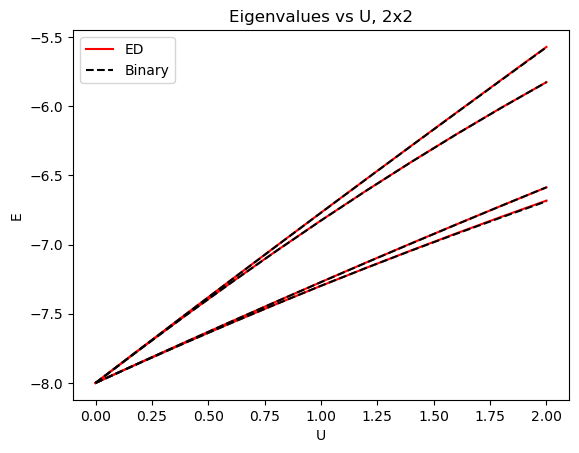

In [22]:
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep_ED, H_eigvals_sweep[band], 'red')
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep, solved_eigvals[band], 'black', linestyle='dashed')

plt.plot(U_sweep_ED[0], H_eigvals_sweep[band][0], 'red', label='ED')
plt.plot(U_sweep[0], solved_eigvals[0, 0], 'black', linestyle='dashed', label='Binary')

plt.xlabel('U')
plt.ylabel('E')
plt.title(f'Eigenvalues vs U, {x_dimension}x{y_dimension}')
# plt.ylim(jnp.min(solved_eigvals) - 0.5, jnp.max(solved_eigvals) + 0.5)

plt.legend()
plt.show()

In [23]:
print(solved_eigvals.T[-1, 0]-H_eigvals_sweep.T[-1, 0])
print(solved_eigvals.T[-1, 1]-H_eigvals_sweep.T[-1, 1])
print(solved_eigvals.T[-1, 2]-H_eigvals_sweep.T[-1, 2])
print(solved_eigvals.T[-1, 3]-H_eigvals_sweep.T[-1, 3])

-0.004684610485581331
0.0005304061555246875
-0.0003849213150424191
-0.0022031817326242376


## error $ = 10^{-6}$

In [24]:
kappa = 80
error = 6
file_name = f'coef_kappa{kappa}_error1e-{error}*'
file = glob.glob(file_name)
pcoefs = loadmat(file[0])
pcoefs = pcoefs['coef_full']

pcoefs = jnp.array([coef[0] for coef in pcoefs])
poly = Chebyshev(pcoefs)

In [25]:
U_sweep = jnp.linspace(0, U, 11)

In [26]:
solved_eigvals = [[vals.item() for vals in H0_eigvals_updated]]

def binary_search_solver(Schur_complement, x0, subspace_eigvals_idx, E_cutoff=10**(-error), max_iter=100):

    def f(x):
        Schur = Schur_complement(x)
        sub_eigvals = jnp.linalg.eigvalsh(Schur)
        return sub_eigvals[subspace_eigvals_idx]

    xn = x0[subspace_eigvals_idx]
    fn = f(x0[subspace_eigvals_idx])

    # Iterative binary search
    for iteration in range(max_iter):
        # Update bounds based on fn's sign
        if fn < 0:
            upper_bound = xn
            lower_bound = fn + xn
        else:
            upper_bound = fn + xn
            lower_bound = xn

        # Update midpoint
        xn = (lower_bound + upper_bound) / 2

        # Update the function value at xn
        fn = f(xn)

        # Check for convergence
        if jnp.abs(fn) < E_cutoff:
            print(f"Converged in {iteration} iterations.")
            print(xn)
            return xn.item()

    print("Binary search did not converge within the maximum number of iterations.")
    print(xn)
    return xn.item()


for i, UU in enumerate(U_sweep):
    # Skip the first iteration
    if i == 0:
        continue
    print('solve:', i)
    
    # Construct the Hamiltonian for the coulomb = U
    H = reduced_hubbard_model(U=float(UU), indices=reduced_H_indices)
    
    # Use binary search to solve the eigenvalues of different band
    solved_eigval = []
    for subspace_eigvals_idx in range(k):
        subspace_solved_eigval = binary_search_solver(Schur_complement=lambda x: Schur_complement_qsp(H=H, E=x, init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx, dim=reduced_dim, poly=poly, kappa=kappa), 
                                                x0=solved_eigvals[-1], subspace_eigvals_idx=subspace_eigvals_idx)
        solved_eigval.append(subspace_solved_eigval)
    solved_eigvals.append(solved_eigval)
solved_eigvals = jnp.array(solved_eigvals).T

solve: 1
Converged in 17 iterations.
-7.85200852031177
Converged in 17 iterations.
-7.850789659105377
Converged in 17 iterations.
-7.752790325943838
Converged in 17 iterations.
-7.75077438032495
solve: 2
Converged in 17 iterations.
-7.7079410942310975
Converged in 17 iterations.
-7.703188148446195
Converged in 17 iterations.
-7.511380202202945
Converged in 17 iterations.
-7.503063588833708
solve: 3
Converged in 17 iterations.
-7.567664691436965
Converged in 17 iterations.
-7.557243134972465
Converged in 17 iterations.
-7.2761037257215655
Converged in 17 iterations.
-7.256822523238082
solve: 4
Converged in 16 iterations.
-7.431049835346684
Converged in 17 iterations.
-7.413002092565921
Converged in 17 iterations.
-7.047287048471952
Converged in 17 iterations.
-7.012005089352149
solve: 5
Converged in 16 iterations.
-7.29797379345481
Converged in 17 iterations.
-7.2705112275807675
Converged in 17 iterations.
-6.825239980357299
Converged in 17 iterations.
-6.7685655090205845
solve: 6
Conve

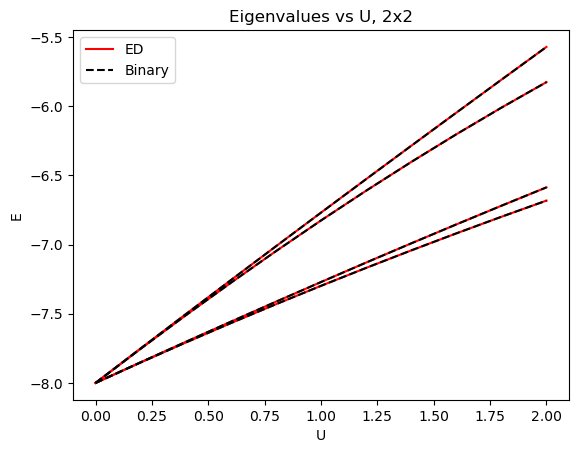

In [28]:
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep_ED, H_eigvals_sweep[band], 'red')
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep, solved_eigvals[band], 'black', linestyle='dashed')

plt.plot(U_sweep_ED[0], H_eigvals_sweep[band][0], 'red', label='ED')
plt.plot(U_sweep[0], solved_eigvals[0, 0], 'black', linestyle='dashed', label='Binary')

plt.xlabel('U')
plt.ylabel('E')
plt.title(f'Eigenvalues vs U, {x_dimension}x{y_dimension}')
# plt.ylim(jnp.min(solved_eigvals) - 0.5, jnp.max(solved_eigvals) + 0.5)

plt.legend()
plt.show()

In [29]:
print(solved_eigvals.T[-1, 0]-H_eigvals_sweep.T[-1, 0])
print(solved_eigvals.T[-1, 1]-H_eigvals_sweep.T[-1, 1])
print(solved_eigvals.T[-1, 2]-H_eigvals_sweep.T[-1, 2])
print(solved_eigvals.T[-1, 3]-H_eigvals_sweep.T[-1, 3])

1.998529723934439e-07
3.0713555698724804e-07
5.25958783192948e-07
5.606744144515119e-07


## error $ = 10^{-8}$

In [30]:
kappa = 80
error = 8
file_name = f'coef_kappa{kappa}_error1e-{error}*'
file = glob.glob(file_name)
pcoefs = loadmat(file[0])
pcoefs = pcoefs['coef_full']

pcoefs = jnp.array([coef[0] for coef in pcoefs])
poly = Chebyshev(pcoefs)

In [31]:
U_sweep = jnp.linspace(0, U, 11)

In [32]:
solved_eigvals = [[vals.item() for vals in H0_eigvals_updated]]

def binary_search_solver(Schur_complement, x0, subspace_eigvals_idx, E_cutoff=10**(-error), max_iter=100):

    def f(x):
        Schur = Schur_complement(x)
        sub_eigvals = jnp.linalg.eigvalsh(Schur)
        return sub_eigvals[subspace_eigvals_idx]

    xn = x0[subspace_eigvals_idx]
    fn = f(x0[subspace_eigvals_idx])

    # Iterative binary search
    for iteration in range(max_iter):
        # Update bounds based on fn's sign
        if fn < 0:
            upper_bound = xn
            lower_bound = fn + xn
        else:
            upper_bound = fn + xn
            lower_bound = xn

        # Update midpoint
        xn = (lower_bound + upper_bound) / 2

        # Update the function value at xn
        fn = f(xn)

        # Check for convergence
        if jnp.abs(fn) < E_cutoff:
            print(f"Converged in {iteration} iterations.")
            print(xn)
            return xn.item()

    print("Binary search did not converge within the maximum number of iterations.")
    print(xn)
    return xn.item()


for i, UU in enumerate(U_sweep):
    # Skip the first iteration
    if i == 0:
        continue
    print('solve:', i)
    
    # Construct the Hamiltonian for the coulomb = U
    H = reduced_hubbard_model(U=float(UU), indices=reduced_H_indices)
    
    # Use binary search to solve the eigenvalues of different band
    solved_eigval = []
    for subspace_eigvals_idx in range(k):
        subspace_solved_eigval = binary_search_solver(Schur_complement=lambda x: Schur_complement_qsp(H=H, E=x, init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx, dim=reduced_dim, poly=poly, kappa=kappa), 
                                                x0=solved_eigvals[-1], subspace_eigvals_idx=subspace_eigvals_idx)
        solved_eigval.append(subspace_solved_eigval)
    solved_eigvals.append(solved_eigval)
solved_eigvals = jnp.array(solved_eigvals).T

solve: 1
Converged in 23 iterations.
-7.852008006386805
Converged in 23 iterations.
-7.850789080844905
Converged in 24 iterations.
-7.752789434376149
Converged in 24 iterations.
-7.750773456816638
solve: 2
Converged in 23 iterations.
-7.707940517274609
Converged in 23 iterations.
-7.703187639150588
Converged in 24 iterations.
-7.511379485129414
Converged in 24 iterations.
-7.503062715928705
solve: 3
Converged in 23 iterations.
-7.567663894679855
Converged in 23 iterations.
-7.557242750199567
Converged in 24 iterations.
-7.276103024405543
Converged in 24 iterations.
-7.256821466952761
solve: 4
Converged in 23 iterations.
-7.43104942426654
Converged in 23 iterations.
-7.413001410231919
Converged in 24 iterations.
-7.047286444695337
Converged in 24 iterations.
-7.0120039093819955
solve: 5
Converged in 23 iterations.
-7.297973450088819
Converged in 23 iterations.
-7.270510370140052
Converged in 23 iterations.
-6.825240025492161
Converged in 24 iterations.
-6.768564872294066
solve: 6
Conver

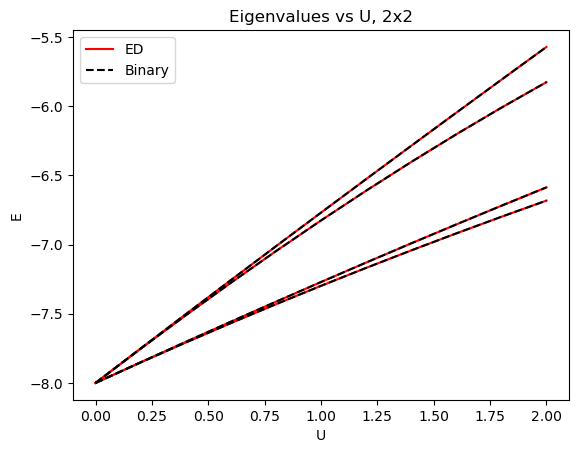

In [34]:
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep_ED, H_eigvals_sweep[band], 'red')
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep, solved_eigvals[band], 'black', linestyle='dashed')

plt.plot(U_sweep_ED[0], H_eigvals_sweep[band][0], 'red', label='ED')
plt.plot(U_sweep[0], solved_eigvals[0, 0], 'black', linestyle='dashed', label='Binary')

plt.xlabel('U')
plt.ylabel('E')
plt.title(f'Eigenvalues vs U, {x_dimension}x{y_dimension}')
# plt.ylim(jnp.min(solved_eigvals) - 0.5, jnp.max(solved_eigvals) + 0.5)

plt.legend()
plt.show()

In [35]:
print(solved_eigvals.T[-1, 0]-H_eigvals_sweep.T[-1, 0])
print(solved_eigvals.T[-1, 1]-H_eigvals_sweep.T[-1, 1])
print(solved_eigvals.T[-1, 2]-H_eigvals_sweep.T[-1, 2])
print(solved_eigvals.T[-1, 3]-H_eigvals_sweep.T[-1, 3])

-5.907870637145152e-09
-4.564872035928147e-09
-1.2237945767878955e-08
-6.9021490745058145e-09


## $\Delta U = 2$

## error $ = 10^{-3}$

In [36]:
kappa = 80
error = 3
file_name = f'coef_kappa{kappa}_error1e-{error}*'
file = glob.glob(file_name)
pcoefs = loadmat(file[0])
pcoefs = pcoefs['coef_full']

pcoefs = jnp.array([coef[0] for coef in pcoefs])
poly = Chebyshev(pcoefs)

In [37]:
U_sweep = jnp.linspace(0, U, 2)

In [38]:
solved_eigvals = [[vals.item() for vals in H0_eigvals_updated]]

def binary_search_solver(Schur_complement, x0, subspace_eigvals_idx, E_cutoff=10**(-error), max_iter=100):

    def f(x):
        Schur = Schur_complement(x)
        sub_eigvals = jnp.linalg.eigvalsh(Schur)
        return sub_eigvals[subspace_eigvals_idx]

    xn = x0[subspace_eigvals_idx]
    fn = f(x0[subspace_eigvals_idx])

    # Iterative binary search
    for iteration in range(max_iter):
        # Update bounds based on fn's sign
        if fn < 0:
            upper_bound = xn
            lower_bound = fn + xn
        else:
            upper_bound = fn + xn
            lower_bound = xn

        # Update midpoint
        xn = (lower_bound + upper_bound) / 2

        # Update the function value at xn
        fn = f(xn)

        # Check for convergence
        if jnp.abs(fn) < E_cutoff:
            print(f"Converged in {iteration} iterations.")
            print(xn)
            return xn.item()

    print("Binary search did not converge within the maximum number of iterations.")
    print(xn)
    return xn.item()


for i, UU in enumerate(U_sweep):
    # Skip the first iteration
    if i == 0:
        continue
    print('solve:', i)
    
    # Construct the Hamiltonian for the coulomb = U
    H = reduced_hubbard_model(U=float(UU), indices=reduced_H_indices)
    
    # Use binary search to solve the eigenvalues of different band
    solved_eigval = []
    for subspace_eigvals_idx in range(k):
        subspace_solved_eigval = binary_search_solver(Schur_complement=lambda x: Schur_complement_qsp(H=H, E=x, init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx, dim=reduced_dim, poly=poly, kappa=kappa), 
                                                x0=solved_eigvals[-1], subspace_eigvals_idx=subspace_eigvals_idx)
        solved_eigval.append(subspace_solved_eigval)
    solved_eigvals.append(solved_eigval)
solved_eigvals = jnp.array(solved_eigvals).T

solve: 1
Converged in 10 iterations.
-6.68609672680742
Converged in 10 iterations.
-6.585518022873051
Converged in 10 iterations.
-5.824966971635016
Converged in 11 iterations.
-5.572381063398483


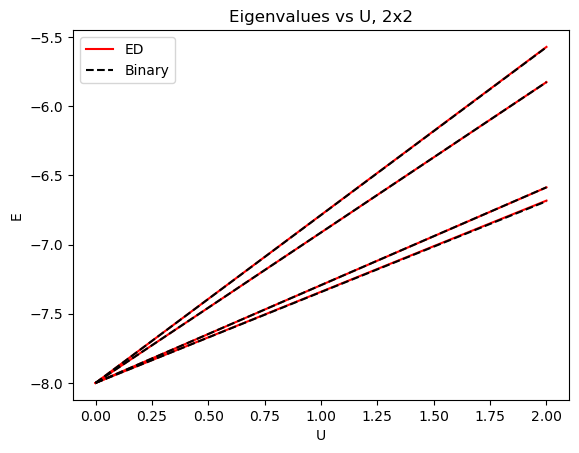

In [40]:
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep_ED, H_eigvals_sweep[band], 'red')
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep, solved_eigvals[band], 'black', linestyle='dashed')

plt.plot(U_sweep_ED[0], H_eigvals_sweep[band][0], 'red', label='ED')
plt.plot(U_sweep[0], solved_eigvals[0, 0], 'black', linestyle='dashed', label='Binary')

plt.xlabel('U')
plt.ylabel('E')
plt.title(f'Eigenvalues vs U, {x_dimension}x{y_dimension}')
# plt.ylim(jnp.min(solved_eigvals) - 0.5, jnp.max(solved_eigvals) + 0.5)

plt.legend()
plt.show()

In [41]:
print(solved_eigvals.T[-1, 0]-H_eigvals_sweep.T[-1, 0])
print(solved_eigvals.T[-1, 1]-H_eigvals_sweep.T[-1, 1])
print(solved_eigvals.T[-1, 2]-H_eigvals_sweep.T[-1, 2])
print(solved_eigvals.T[-1, 3]-H_eigvals_sweep.T[-1, 3])

-0.0044014923107296156
0.0003847385193145314
-2.1078405719521243e-05
-0.0018593337391648035


# Wegstien's method
### ($\Delta U = 0.2$)

## error $ = 10^{-3}$

In [42]:
kappa = 80
error = 3
file_name = f'coef_kappa{kappa}_error1e-{error}*'
file = glob.glob(file_name)
pcoefs = loadmat(file[0])
pcoefs = pcoefs['coef_full']

pcoefs = jnp.array([coef[0] for coef in pcoefs])
poly = Chebyshev(pcoefs)

In [43]:
U_sweep = jnp.linspace(0, U, 11)

In [44]:
solved_eigvals = [[vals.item() for vals in H0_eigvals_updated]]

def Wegstein_solver(Schur_complement, x0, subspace_eigvals_idx, E_cutoff=10**(-error), max_iter=100):

    def f(x):
        Schur = Schur_complement(x)
        sub_eigvals = jnp.linalg.eigvalsh(Schur)
        return sub_eigvals[subspace_eigvals_idx] + x
    
    # Initialize xn and fn
    xn = [x0[subspace_eigvals_idx], f(x0[subspace_eigvals_idx])]
    fn = [xn[1], f(xn[1])]    
    
    for i in range(1, max_iter):
        
        x_new = (xn[i-1]*fn[i] - xn[i]*fn[i-1]) / (xn[i-1] + fn[i] - xn[i] - fn[i-1])
        xn.append(x_new)
        fn.append(f(x_new))
        
        # If the energy difference is less than cutoff, the algorithm converge
        if abs(x_new - xn[i]) < E_cutoff:
            print(f"Converged in {i} iterations.")
            print(fn[-1])
            return fn[-1]
    
    print("Wegstein method did not converge within the maximum number of iterations.")
    print(fn[-1])   
    return fn[-1]


for i, UU in enumerate(U_sweep):
    # Skip the first iteration
    if i == 0:
        continue
    print('solve:', i)
    
    # Construct the Hamiltonian for the coulomb = U
    H = reduced_hubbard_model(U=float(UU), indices=reduced_H_indices)
    
    # Use binary search to solve the eigenvalues of different band
    solved_eigval = []
    for subspace_eigvals_idx in range(k):
        subspace_solved_eigval = Wegstein_solver(Schur_complement=lambda x: Schur_complement_qsp(H=H, E=x, init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx, dim=reduced_dim, poly=poly, kappa=kappa), 
                                                x0=solved_eigvals[-1], subspace_eigvals_idx=subspace_eigvals_idx)
        solved_eigval.append(subspace_solved_eigval)
    solved_eigvals.append(solved_eigval)
solved_eigvals = jnp.array(solved_eigvals).T

solve: 1
Converged in 1 iterations.
-7.852055190929633
Converged in 1 iterations.
-7.8507907366899365
Converged in 1 iterations.
-7.752806403621142
Converged in 1 iterations.
-7.750782462429153
solve: 2
Converged in 1 iterations.
-7.708061038756672
Converged in 1 iterations.
-7.703166912386695
Converged in 1 iterations.
-7.511429256591132
Converged in 1 iterations.
-7.503080822420675
solve: 3
Converged in 1 iterations.
-7.567590271699731
Converged in 1 iterations.
-7.55716830218296
Converged in 2 iterations.
-7.276131853920197
Converged in 1 iterations.
-7.256792465469792
solve: 4
Converged in 1 iterations.
-7.430449365201172
Converged in 1 iterations.
-7.412913521664587
Converged in 2 iterations.
-7.04720009945937
Converged in 1 iterations.
-7.011846632229623
solve: 5
Converged in 1 iterations.
-7.296958745845595
Converged in 1 iterations.
-7.270544146224048
Converged in 2 iterations.
-6.82500476738341
Converged in 1 iterations.
-6.768275649841051
solve: 6
Converged in 1 iterations.
-

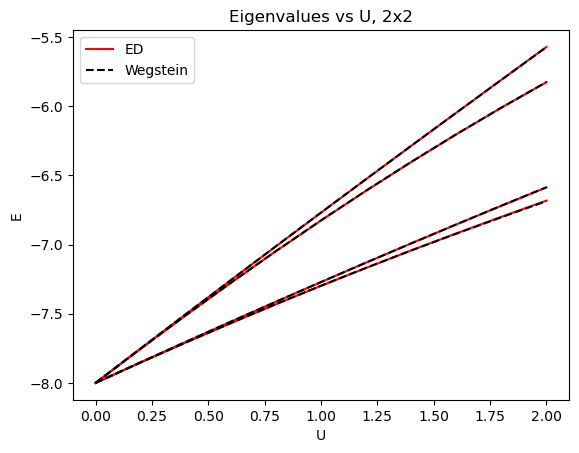

In [46]:
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep_ED, H_eigvals_sweep[band], 'red')
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep, solved_eigvals[band], 'black', linestyle='dashed')

plt.plot(U_sweep_ED[0], H_eigvals_sweep[band][0], 'red', label='ED')
plt.plot(U_sweep[0], solved_eigvals[0, 0], 'black', linestyle='dashed', label='Wegstein')

plt.xlabel('U')
plt.ylabel('E')
plt.title(f'Eigenvalues vs U, {x_dimension}x{y_dimension}')
# plt.ylim(jnp.min(solved_eigvals) - 0.5, jnp.max(solved_eigvals) + 0.5)

plt.legend()
plt.show()

In [47]:
print(solved_eigvals.T[-1, 0]-H_eigvals_sweep.T[-1, 0])
print(solved_eigvals.T[-1, 1]-H_eigvals_sweep.T[-1, 1])
print(solved_eigvals.T[-1, 2]-H_eigvals_sweep.T[-1, 2])
print(solved_eigvals.T[-1, 3]-H_eigvals_sweep.T[-1, 3])

-0.0039000310902057578
0.0010295140339762199
0.0004276759860921686
-0.0012938892896388055


## error $ = 10^{-6}$

In [48]:
kappa = 80
error = 6
file_name = f'coef_kappa{kappa}_error1e-{error}*'
file = glob.glob(file_name)
pcoefs = loadmat(file[0])
pcoefs = pcoefs['coef_full']

pcoefs = jnp.array([coef[0] for coef in pcoefs])
poly = Chebyshev(pcoefs)

In [49]:
U_sweep = jnp.linspace(0, U, 11)

In [50]:
solved_eigvals = [[vals.item() for vals in H0_eigvals_updated]]

def Wegstein_solver(Schur_complement, x0, subspace_eigvals_idx, E_cutoff=10**(-error), max_iter=100):

    def f(x):
        Schur = Schur_complement(x)
        sub_eigvals = jnp.linalg.eigvalsh(Schur)
        return sub_eigvals[subspace_eigvals_idx] + x
    
    # Initialize xn and fn
    xn = [x0[subspace_eigvals_idx], f(x0[subspace_eigvals_idx])]
    fn = [xn[1], f(xn[1])]    
    
    for i in range(1, max_iter):
        
        x_new = (xn[i-1]*fn[i] - xn[i]*fn[i-1]) / (xn[i-1] + fn[i] - xn[i] - fn[i-1])
        xn.append(x_new)
        fn.append(f(x_new))
        
        # If the energy difference is less than cutoff, the algorithm converge
        if abs(x_new - xn[i]) < E_cutoff:
            print(f"Converged in {i} iterations.")
            print(fn[-1])
            return fn[-1]
    
    print("Wegstein method did not converge within the maximum number of iterations.")
    print(fn[-1])   
    return fn[-1]


for i, UU in enumerate(U_sweep):
    # Skip the first iteration
    if i == 0:
        continue
    print('solve:', i)
    
    # Construct the Hamiltonian for the coulomb = U
    H = reduced_hubbard_model(U=float(UU), indices=reduced_H_indices)
    
    # Use binary search to solve the eigenvalues of different band
    solved_eigval = []
    for subspace_eigvals_idx in range(k):
        subspace_solved_eigval = Wegstein_solver(Schur_complement=lambda x: Schur_complement_qsp(H=H, E=x, init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx, dim=reduced_dim, poly=poly, kappa=kappa), 
                                                x0=solved_eigvals[-1], subspace_eigvals_idx=subspace_eigvals_idx)
        solved_eigval.append(subspace_solved_eigval)
    solved_eigvals.append(solved_eigval)
solved_eigvals = jnp.array(solved_eigvals).T

solve: 1
Converged in 2 iterations.
-7.85200795817295
Converged in 2 iterations.
-7.850789090826232
Converged in 2 iterations.
-7.752789393567719
Converged in 2 iterations.
-7.750773431070307
solve: 2
Converged in 2 iterations.
-7.707940553719706
Converged in 2 iterations.
-7.703187589073066
Converged in 2 iterations.
-7.511379324171885
Converged in 2 iterations.
-7.503062649602388
solve: 3
Converged in 2 iterations.
-7.567664175515976
Converged in 2 iterations.
-7.557242586560692
Converged in 2 iterations.
-7.276102923720596
Converged in 2 iterations.
-7.256821596393017
solve: 4
Converged in 2 iterations.
-7.431048853558377
Converged in 2 iterations.
-7.413001557141068
Converged in 3 iterations.
-7.047286340683077
Converged in 2 iterations.
-7.0120041769972685
solve: 5
Converged in 2 iterations.
-7.297972866551556
Converged in 2 iterations.
-7.270510707114272
Converged in 3 iterations.
-6.825239379404481
Converged in 2 iterations.
-6.7685646129756565
solve: 6
Converged in 2 iterations

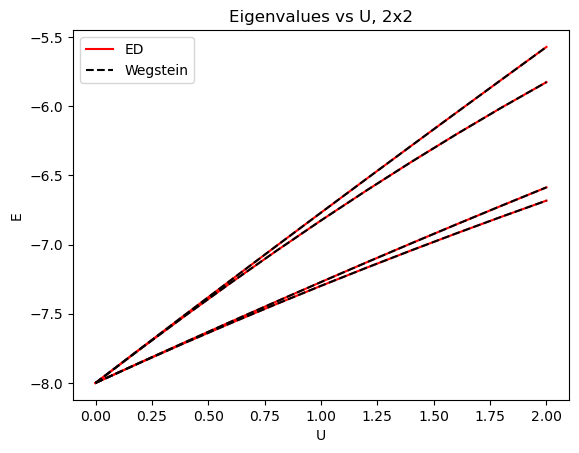

In [52]:
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep_ED, H_eigvals_sweep[band], 'red')
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep, solved_eigvals[band], 'black', linestyle='dashed')

plt.plot(U_sweep_ED[0], H_eigvals_sweep[band][0], 'red', label='ED')
plt.plot(U_sweep[0], solved_eigvals[0, 0], 'black', linestyle='dashed', label='Wegstein')

plt.xlabel('U')
plt.ylabel('E')
plt.title(f'Eigenvalues vs U, {x_dimension}x{y_dimension}')
# plt.ylim(jnp.min(solved_eigvals) - 0.5, jnp.max(solved_eigvals) + 0.5)

plt.legend()
plt.show()

In [53]:
print(solved_eigvals.T[-1, 0]-H_eigvals_sweep.T[-1, 0])
print(solved_eigvals.T[-1, 1]-H_eigvals_sweep.T[-1, 1])
print(solved_eigvals.T[-1, 2]-H_eigvals_sweep.T[-1, 2])
print(solved_eigvals.T[-1, 3]-H_eigvals_sweep.T[-1, 3])

8.448476656042203e-07
1.1549702945146123e-06
1.1472062659834137e-06
1.355611156661496e-06


## error $ = 10^{-8}$

In [54]:
kappa = 80
error = 8
file_name = f'coef_kappa{kappa}_error1e-{error}*'
file = glob.glob(file_name)
pcoefs = loadmat(file[0])
pcoefs = pcoefs['coef_full']

pcoefs = jnp.array([coef[0] for coef in pcoefs])
poly = Chebyshev(pcoefs)

In [55]:
U_sweep = jnp.linspace(0, U, 11)

In [56]:
solved_eigvals = [[vals.item() for vals in H0_eigvals_updated]]

def Wegstein_solver(Schur_complement, x0, subspace_eigvals_idx, E_cutoff=10**(-error), max_iter=100):

    def f(x):
        Schur = Schur_complement(x)
        sub_eigvals = jnp.linalg.eigvalsh(Schur)
        return sub_eigvals[subspace_eigvals_idx] + x
    
    # Initialize xn and fn
    xn = [x0[subspace_eigvals_idx], f(x0[subspace_eigvals_idx])]
    fn = [xn[1], f(xn[1])]    
    
    for i in range(1, max_iter):
        
        x_new = (xn[i-1]*fn[i] - xn[i]*fn[i-1]) / (xn[i-1] + fn[i] - xn[i] - fn[i-1])
        xn.append(x_new)
        fn.append(f(x_new))
        
        # If the energy difference is less than cutoff, the algorithm converge
        if abs(x_new - xn[i]) < E_cutoff:
            print(f"Converged in {i} iterations.")
            print(fn[-1])
            return fn[-1]
    
    print("Wegstein method did not converge within the maximum number of iterations.")
    print(fn[-1])   
    return fn[-1]


for i, UU in enumerate(U_sweep):
    # Skip the first iteration
    if i == 0:
        continue
    print('solve:', i)
    
    # Construct the Hamiltonian for the coulomb = U
    H = reduced_hubbard_model(U=float(UU), indices=reduced_H_indices)
    
    # Use binary search to solve the eigenvalues of different band
    solved_eigval = []
    for subspace_eigvals_idx in range(k):
        subspace_solved_eigval = Wegstein_solver(Schur_complement=lambda x: Schur_complement_qsp(H=H, E=x, init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx, dim=reduced_dim, poly=poly, kappa=kappa), 
                                                x0=solved_eigvals[-1], subspace_eigvals_idx=subspace_eigvals_idx)
        solved_eigval.append(subspace_solved_eigval)
    solved_eigvals.append(solved_eigval)
solved_eigvals = jnp.array(solved_eigvals).T

solve: 1
Converged in 2 iterations.
-7.852007997615887
Converged in 2 iterations.
-7.850789071970249
Converged in 2 iterations.
-7.752789427124383
Converged in 2 iterations.
-7.750773449405057
solve: 2
Converged in 2 iterations.
-7.7079405088760735
Converged in 2 iterations.
-7.7031876304295634
Converged in 20 iterations.
-7.511379478208422
Converged in 2 iterations.
-7.503062708608352
solve: 3
Converged in 2 iterations.
-7.567663886716048
Converged in 2 iterations.
-7.557242741673583
Converged in 33 iterations.
-7.276103018347501
Converged in 2 iterations.
-7.2568214597495375
solve: 4
Converged in 5 iterations.
-7.431049416731243
Converged in 2 iterations.
-7.413001401941731
Converged in 3 iterations.
-7.0472864396109705
Converged in 8 iterations.
-7.012003902299874
solve: 5
Converged in 14 iterations.
-7.29797344302976
Converged in 19 iterations.
-7.270510362128334
Converged in 3 iterations.
-6.82524001712888
Converged in 19 iterations.
-6.768564865373581
solve: 6
Converged in 10 ite

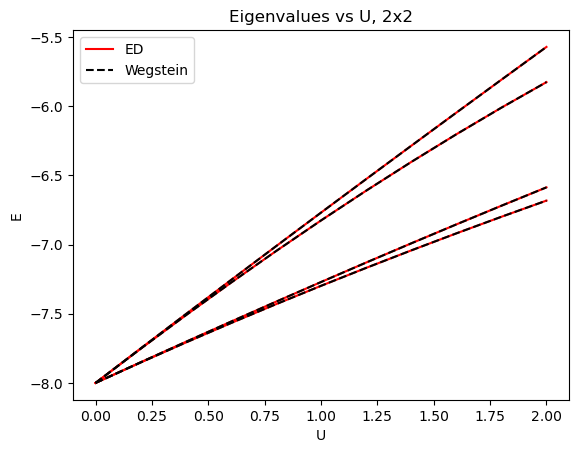

In [58]:
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep_ED, H_eigvals_sweep[band], 'red')
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep, solved_eigvals[band], 'black', linestyle='dashed')

plt.plot(U_sweep_ED[0], H_eigvals_sweep[band][0], 'red', label='ED')
plt.plot(U_sweep[0], solved_eigvals[0, 0], 'black', linestyle='dashed', label='Wegstein')

plt.xlabel('U')
plt.ylabel('E')
plt.title(f'Eigenvalues vs U, {x_dimension}x{y_dimension}')
# plt.ylim(jnp.min(solved_eigvals) - 0.5, jnp.max(solved_eigvals) + 0.5)

plt.legend()
plt.show()

In [59]:
print(solved_eigvals.T[-1, 0]-H_eigvals_sweep.T[-1, 0])
print(solved_eigvals.T[-1, 1]-H_eigvals_sweep.T[-1, 1])
print(solved_eigvals.T[-1, 2]-H_eigvals_sweep.T[-1, 2])
print(solved_eigvals.T[-1, 3]-H_eigvals_sweep.T[-1, 3])

3.010757865240521e-09
1.5259535857126139e-09
-1.2833591078731388e-08
-9.76974945388065e-10


## $\Delta U = 2$

## error $ = 10^{-3}$

In [60]:
kappa = 80
error = 3
file_name = f'coef_kappa{kappa}_error1e-{error}*'
file = glob.glob(file_name)
pcoefs = loadmat(file[0])
pcoefs = pcoefs['coef_full']

pcoefs = jnp.array([coef[0] for coef in pcoefs])
poly = Chebyshev(pcoefs)

In [61]:
U_sweep = jnp.linspace(0, U, 2)

In [62]:
solved_eigvals = [[vals.item() for vals in H0_eigvals_updated]]

def Wegstein_solver(Schur_complement, x0, subspace_eigvals_idx, E_cutoff=10**(-error), max_iter=100):

    def f(x):
        Schur = Schur_complement(x)
        sub_eigvals = jnp.linalg.eigvalsh(Schur)
        return sub_eigvals[subspace_eigvals_idx] + x
    
    # Initialize xn and fn
    xn = [x0[subspace_eigvals_idx], f(x0[subspace_eigvals_idx])]
    fn = [xn[1], f(xn[1])]    
    
    for i in range(1, max_iter):
        
        x_new = (xn[i-1]*fn[i] - xn[i]*fn[i-1]) / (xn[i-1] + fn[i] - xn[i] - fn[i-1])
        xn.append(x_new)
        fn.append(f(x_new))
        
        # If the energy difference is less than cutoff, the algorithm converge
        if abs(x_new - xn[i]) < E_cutoff:
            print(f"Converged in {i} iterations.")
            print(fn[-1])
            return fn[-1]
    
    print("Wegstein method did not converge within the maximum number of iterations.")
    print(fn[-1])   
    return fn[-1]


for i, UU in enumerate(U_sweep):
    # Skip the first iteration
    if i == 0:
        continue
    print('solve:', i)
    
    # Construct the Hamiltonian for the coulomb = U
    H = reduced_hubbard_model(U=float(UU), indices=reduced_H_indices)
    
    # Use binary search to solve the eigenvalues of different band
    solved_eigval = []
    for subspace_eigvals_idx in range(k):
        subspace_solved_eigval = Wegstein_solver(Schur_complement=lambda x: Schur_complement_qsp(H=H, E=x, init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx, dim=reduced_dim, poly=poly, kappa=kappa), 
                                                x0=solved_eigvals[-1], subspace_eigvals_idx=subspace_eigvals_idx)
        solved_eigval.append(subspace_solved_eigval)
    solved_eigvals.append(solved_eigval)
solved_eigvals = jnp.array(solved_eigvals).T

solve: 1
Converged in 2 iterations.
-6.685595265591587
Converged in 2 iterations.
-6.584873250044355
Converged in 3 iterations.
-5.824518227544723
Converged in 2 iterations.
-5.571815615899649


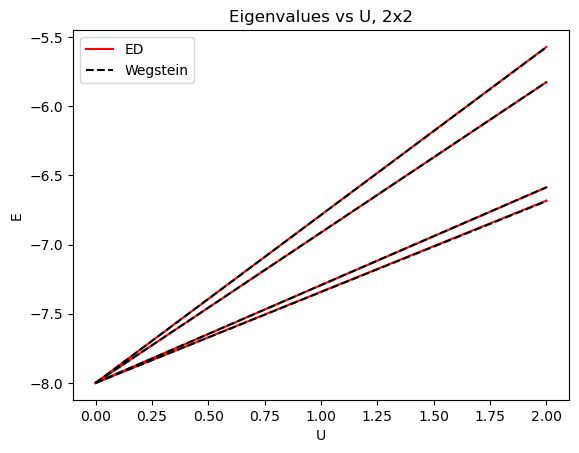

In [64]:
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep_ED, H_eigvals_sweep[band], 'red')
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep, solved_eigvals[band], 'black', linestyle='dashed')

plt.plot(U_sweep_ED[0], H_eigvals_sweep[band][0], 'red', label='ED')
plt.plot(U_sweep[0], solved_eigvals[0, 0], 'black', linestyle='dashed', label='Wegstein')

plt.xlabel('U')
plt.ylabel('E')
plt.title(f'Eigenvalues vs U, {x_dimension}x{y_dimension}')
# plt.ylim(jnp.min(solved_eigvals) - 0.5, jnp.max(solved_eigvals) + 0.5)

plt.legend()
plt.show()

In [65]:
print(solved_eigvals.T[-1, 0]-H_eigvals_sweep.T[-1, 0])
print(solved_eigvals.T[-1, 1]-H_eigvals_sweep.T[-1, 1])
print(solved_eigvals.T[-1, 2]-H_eigvals_sweep.T[-1, 2])
print(solved_eigvals.T[-1, 3]-H_eigvals_sweep.T[-1, 3])

-0.003900031094897116
0.0010295113480109919
0.00042766568457341947
-0.001293886240330444
